In [1]:
import sys
sys.path.insert(0, '/Users/kedzie/repos/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
import bokeh
import scipy
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from collections.abc import Iterable


from utility_functions.utils import read_data, read_press, getnearpos, folder_files, headspace
from utility_functions.utils import getnearpos


In [75]:

#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)
def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    
    m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    m = [1.463, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    
    #inf_ar = 278.6590323 * demsdata['36']
    #inf_o2 = 278.6590323 * demsdata['31']   #as of 2/2019
    #inf_ar = demsdata['40']
    inf_o2 =  demsdata['16'] /0.108107424
    
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] = (m[2]* demsdata['2'] )/inf_o2 * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    
    return (demsdata) 


def baselinecorr(data, mz, end1, start2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    
    index = getnearpos(data['time/min'], end1/60)
    index2 = getnearpos(data['time/min'], start2)
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--')

    
    if mz == 2:
        #cell 17 4/26 correction1: 
        #correct= -1.19042*10**-5*data['time/min'] + 4.70975*10**-3
        #cell 18 correct= 5.45705*10**-12*data['time/min']**4 - 3.48588*10**-9*data['time/min']**3 + 8.38975*10**-7*data['time/min']**2 - 8.88079*10**-5*data['time/min']+5.55649*10**-3
        # correct = -0.2179834 * data['time/min'] + 2.396152*10**2 #cell 17 with ar
        #cell 19 correct = -7.99561*10**-7 * data['time/min'] + 2.99082*10**-3
        #cell 20
        #correct = -1.56453*10**-6* data['time/min'] + 3.58403*10**-3
        #correct = -2.32525*10**-6*data['time/min'] + 8.70813*10**-4
        correct = 0*data['time/min']+0.01
    plt.plot(data['time/min'], correct, '.')
    data[str(mz)] = data[str(mz)]-correct
    
    return (data)



17


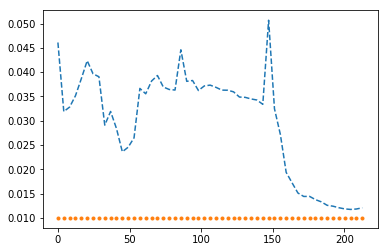

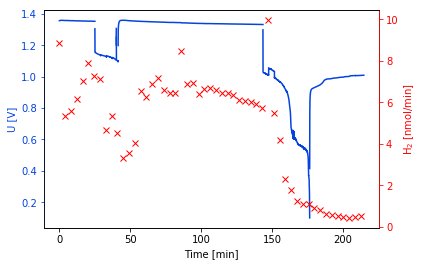

In [77]:
zn_17= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell17_dems/190426_cell17_dems_2019-04-26_12.01_19_ch1.txt')
zn_17_eclab= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell17_dems/')

#umoles17 = convert_ion_current(zn_17) 
#umoles17.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/2019/convertedcurrentszn17_ar.csv')

plot_zn_dems(zn_17_eclab, zn_17)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell17_dems/cell17plot_argoncorrect.png', transparent = True, dpi=600, bbox_inches='tight')

zn_18= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell18_dems/190426_cell18_2019-04-26_12.01_19_ch2.txt')
zn_18_eclab= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell18_dems/')
#plot_zn_dems(zn_18_eclab, zn_18)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell18_dems/cell18plot.png', transparent = True, dpi=600, bbox_inches='tight')



#umoles18 = convert_ion_current(zn_18) 
#umoles18.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/2019/convertedcurrentszn18.csv')



zn_19= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell19_dems/190426_Cell19_2019-04-26_16.22_11_ch1.txt')
zn_19_eclab= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell19_dems/')
#umoles19 = convert_ion_current(zn_19) 
#umoles19.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/2019/convertedcurrentszn19.csv')


#plot_zn_dems(zn_19_eclab, zn_19)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell19_dems/cell19plot.png', transparent = True, dpi=600, bbox_inches='tight')

zn_20= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell20_dems/190426_Cell20_2019-04-26_16.22_11_ch2.txt')
zn_20_eclab= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell20_dems/')
#umoles20 = convert_ion_current(zn_20) 
#umoles20.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/2019/convertedcurrent_zn20.csv')
#plot_zn_dems(zn_20_eclab, zn_20)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190426_znair_raj_dems/190426_cell20_dems/cell20plot.png', transparent = True, dpi=600, bbox_inches='tight')



zn_3= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell3/Cell3_2019-03-08_14.44_13_ch1.txt')
zn_3_eclab= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell3/')

#plot_zn_dems(zn_3_eclab, zn_3)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell3/cell3plot.png', transparent = True, dpi=600, bbox_inches='tight')


zn_9= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell9/Cell9_2019-03-08_14.44_13_ch2.txt')
zn_9_eclab= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell9/')
#plot_zn_dems(zn_9_eclab, zn_9)
#plt.savefig('/Users/kedzie/Desktop/cell9plot.png', transparent = True, dpi=600, bbox_inches='tight')



zn_12= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell12/Cell12_2019-03-08_17.36_26_ch2.txt')
zn_12_eclab= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell12/')
#plot_zn_dems(zn_12_eclab, zn_12)
#plt.savefig('/Users/kedzie/Desktop/cell12plot.png', transparent = True, dpi=600, bbox_inches='tight')

zn_16= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell16/Cell16_2019-03-08_17.36_26_ch1.txt')
zn_16_eclab= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Raj Zn Corrosion/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell16/')
#plot_zn_dems(zn_16_eclab, zn_16)

#plt.savefig('/Users/kedzie/Desktop/cell16plot.png', transparent = True, dpi=600, bbox_inches='tight')



In [72]:
#plot chronoamperometric charge on DEMS
def plot_zn_dems(chrg_ec, demi,  n=2 ):
    print(len(chrg_ec))
    end_ocv= chrg_ec[0]['time/s'].iloc[-1]  #cell 17: change index to 6
    #convert ion current to moles of gas for raw  data
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    hydro = baselinecorr( demi, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    umolesdf=hydro
    area_cath=1
    
    #pdb.set_trace()
    
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    fig,ax = plt.subplots(facecolor='white')
    ax2=ax.twinx()
    
    umoles_2 = np.cumsum(umolesdf['2']).iloc[-1]
    
    for i in range(7):
        ax.plot(chrg_ec[i]['time/s']/60 , chrg_ec[i]['Ewe/V'] , color='xkcd:blue')
    ax2.plot(umolesdf['time/min'], (umolesdf['2'])/timediff*10**3 , 'rx', markersize=6, label= '2')
    
    #ax.fill_between([27,32], 1.4, color='xkcd:blue', alpha=0.2)
    #ax.fill_between([143,176], 1.4, color='xkcd:blue', alpha=0.2)
    ax2.spines['right'].set_color('red')
    ax2.tick_params(axis='y', colors='red')
    ax.spines['left'].set_color('xkcd:blue')
    ax.tick_params(axis='y', colors='xkcd:blue')
    
    ax.set_xlabel('Time [min]')
    ax.set_ylabel('U [V]' , color='xkcd:blue')
    ax2.set_ylabel('H$_2$ [nmol/min]', color='red')
    #$\mu$
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    
    
    return

